# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [1]:
# !pip install pandas==1.5.1

In [2]:
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman',

    'Brush',
    'Brush wo split',
    'Brush (D-UCB1)',
    'Brush (C-D-UCB1)',
    'Brush (D-TS)',
    'Brush (C-D-TS)',
    'Brush wo split (D-UCB1)',
    
    # Fixed labels
    'Brush w/ split (no MAB)',

    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    # short fixed labels
    'Brush_0',
    'Brush+S',
    'Brush+M',
    'Brush+SM',
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman'
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',

    'Brush',
    'Brush wo split',
    'Brush (D-UCB1)',
    'Brush (C-D-UCB1)',
    'Brush (D-TS)',
    'Brush (C-D-TS)',
    'Brush wo split (D-UCB1)',
    
    # Fixed labels
    'Brush w/ split (no MAB)',

    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    # short fixed labels
    'Brush_0',
    'Brush+S',
    'Brush+M',
    'Brush+SM',
]

In [3]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('ps', fonttype=42)

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

import os
sns.set(font_scale=1.25, style='whitegrid')
sns.set(palette='magma')

rdir = '../results_blackbox/'
pstreedir = '../results_blackbox_pstree/'
figdir = '../paper/'
datadir = '../datasets/pmlb/datasets/'
print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')

figdir: ../paper/


# read data from feather

In [4]:
##########
# load results
##########
df_results = pd.read_feather('../results/black-box_results_srbench.feather')

# df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_500_dom.feather'), df_results], axis=0)
# df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_500.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_brush_250.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_pstree.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_dso.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_tpsr.feather'), df_results], axis=0)
df_results = pd.concat([pd.read_feather('../results/black-box_results_e2et.feather'), df_results], axis=0)

# df_results.reset_index()

df_results['algorithm'] = df_results['algorithm'].str.replace(r'^Brush$', r'Brush w/ split (no MAB)', regex=True)
df_results['algorithm'] = df_results['algorithm'].str.replace(r'^Brush wo split$', r'Brush w/o split (no MAB)', regex=True)
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush wo', r'Brush w/o'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush (', r'Brush w/ split ('))

# Short labels
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/o split (no MAB)',r'$Brush_0$'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (no MAB)','Brush+S'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/o split (D-UCB1)','Brush+M'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (D-UCB1)','Brush+SM'))

# Visualize different mabs.
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush+SM','Brush+M (D-UCB1)'))
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (C-D-UCB1)','Brush+M (C-D-UCB1)'))
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (D-TS)','Brush+M (D-TS)'))
# df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Brush w/ split (C-D-TS)','Brush+M (C-D-TS)'))

# Removing mislabeled datasets (these are clf, but PMLB v1.0 had it as regr)
df_results = df_results[ ~df_results["dataset"].isin(["banana", "titanic"]) ]

print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

mean trial count:
algorithm
AIFeynman                    7.688525
TPSR+E2E                     9.073770
MRGP                         9.745902
FEAT                         9.827869
Operon                       9.836066
MLP                          9.836066
Linear                       9.836066
LGBM                         9.836066
KernelRidge                  9.836066
ITEA                         9.836066
GP-GOMEA                     9.836066
FFX                          9.836066
gplearn                      9.836066
EPLEX                        9.836066
RandomForest                 9.836066
DSR                          9.836066
SBP-GP                       9.836066
XGB                          9.836066
BSR                          9.836066
AdaBoost                     9.836066
AFP_FE                       9.836066
AFP                          9.836066
PS-Tree                      9.836066
E2E                          9.868852
Brush+S                      9.942623
Brush w/ split (D-TS) 

In [5]:
df_results['dataset'].nunique()

122

In [6]:
df_results.sample(2)

,dataset,algorithm,random_state,training time (s),symbolic_model,mse_test,mae_test,r2_test,model_size,params_str,training time (hr),r2_zero_test,friedman_dataset,symbolic_alg
13019,596_fri_c2_250_5,RandomForest,5390,80.281940,not implemented,0.174060,0.343490,0.833694,236254,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.022301,0.833694,True,False
268,607_fri_c4_1000_50,Brush w/ split (C-D-UCB1),29910,559.164686,"1.04*Add(1.00*Sub(Sin(Sub(Add(-1.19*oz1,-0.17*...",0.267023,0.350824,0.732586,26,"{'pop_size': 1000, 'max_gen': 250, 'verbosity'...",0.155324,0.732586,True,True


In [7]:
df_results['algorithm'].value_counts()

Brush+M                      1217
Brush w/ split (C-D-TS)      1216
Brush+SM                     1215
uDSR                         1215
$Brush_0$                    1215
Brush w/ split (C-D-UCB1)    1214
Brush+S                      1213
Brush w/ split (D-TS)        1213
E2E                          1204
GP-GOMEA                     1200
Linear                       1200
SBP-GP                       1200
RandomForest                 1200
Operon                       1200
MLP                          1200
LGBM                         1200
KernelRidge                  1200
ITEA                         1200
gplearn                      1200
EPLEX                        1200
FFX                          1200
AFP_FE                       1200
DSR                          1200
BSR                          1200
AFP                          1200
AdaBoost                     1200
PS-Tree                      1200
XGB                          1200
FEAT                         1199
MRGP          

In [8]:
# ignoring new datasets from PMLB that hasnt been benchmarked with other methods yet
# df_results[['algorithm', 'dataset']].value_counts().unstack().sum(axis=0).sort_values()

print(df_results.shape)
df_results = df_results[ ~df_results["dataset"].isin([
                                                        "nikuradse_2",
                                                        "nikuradse_1"
]) ]

print(df_results.shape)


(38155, 14)
(37955, 14)


In [9]:
# removing specific models (for results reporting --- there is several papers using these results)

print(df_results.shape)
df_results = df_results[ ~df_results["algorithm"].isin([
    # Comment out which you want to use in the plots
    
    # 'Brush_0',
    # 'Brush+S',
    # 'Brush+M',
    # 'Brush+SM',

    'Brush w/ split (no MAB)',
    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    # "uDSR",
    # "E2E",
    # "TPSR+E2E",
    # "NeSymRes 10M",
    # "NeSymRes 100M",
]) ]

print(df_results.shape)

(37955, 14)
(34372, 14)


## summarize results by dataset, including ranking

In [10]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))
display(df_results2)
                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    print(col)
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
###################
# save summary data
###################
df_sum.to_csv('../results/results_black-box_summary.csv.gz',compression='gzip',index=False)

df_sum

,dataset,algorithm,random_state,training time (s),symbolic_model,mse_test,mae_test,r2_test,model_size,params_str,training time (hr),r2_zero_test,friedman_dataset,symbolic_alg,algorithm_count
0,195_auto_price,E2E,29910,49.275633,((((((0.0639 * (1.7539657868027682e-16 + (1.0 ...,4.103267e+07,5216.805914,-1.436411,173,{'random_state': 29910},0.013688,0.000000,False,False,29
1,195_auto_price,E2E,21962,35.792376,((-0.29100000000000004 + (0.386 * cos((-83.9 *...,4.377146e+07,4266.222237,-0.077704,134,{'random_state': 21962},0.009942,0.000000,False,False,29
2,195_auto_price,E2E,5390,29.430627,(((-0.0009199999999999999 + sin((((6.66 * (-1....,3.178467e+07,4284.890042,-0.064812,134,{'random_state': 5390},0.008175,0.000000,False,False,29
3,195_auto_price,E2E,28020,25.471130,((0.009 + (0.002 * (-2.3347337135499616e-16 + ...,2.640492e+07,3784.497525,0.343112,102,{'random_state': 28020},0.007075,0.343112,False,False,29
4,195_auto_price,E2E,860,36.969272,((((0.9600000000000001 + (-2.3697197332335274e...,3.202829e+07,4451.197984,-0.993365,150,{'random_state': 860},0.010269,0.000000,False,False,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34367,1030_ERA,XGB,23654,138.144130,not implemented,2.677263e+00,1.317680,0.333683,6978,"{'objective': 'reg:squarederror', 'base_score'...",0.038373,0.333683,False,False,29
34368,1030_ERA,XGB,29802,144.100733,not implemented,2.374513e+00,1.233534,0.452916,6562,"{'objective': 'reg:squarederror', 'base_score'...",0.040028,0.452916,False,False,29
34369,1030_ERA,XGB,5390,164.314219,not implemented,2.503823e+00,1.293553,0.380448,6536,"{'objective': 'reg:squarederror', 'base_score'...",0.045643,0.380448,False,False,29
34370,1030_ERA,XGB,6265,156.933141,not implemented,2.548855e+00,1.289732,0.354495,282,"{'objective': 'reg:squarederror', 'base_score'...",0.043593,0.354495,False,False,29


mse_test


/tmp/ipykernel_363322/1819385102.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x:


mae_test


/tmp/ipykernel_363322/1819385102.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x:


r2_test


/tmp/ipykernel_363322/1819385102.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x:
/tmp/ipykernel_363322/1819385102.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank

model_size
r2_zero_test


/tmp/ipykernel_363322/1819385102.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x:
/tmp/ipykernel_363322/1819385102.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
/tmp/ipykernel_363322/1819385102.py:21: FutureWarning: Not prepending group keys to the result index

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,$Brush_0$,1027_ESL,16322.5,98.357619,0.291673,0.402997,0.848021,15.5,0.027322,0.848021,...,14.0,0.954137,7.0,0.000536,14.0,0.954137,13.5,0.044122,13.5,0.037952
1,$Brush_0$,1028_SWD,16322.5,140.126186,0.404924,0.509741,0.368418,29.0,0.038924,0.368418,...,4.0,0.941664,7.0,0.000230,4.0,0.932275,11.0,0.079070,11.0,0.075570
2,$Brush_0$,1029_LEV,16322.5,131.053647,0.421652,0.487497,0.548548,20.0,0.036404,0.548548,...,7.0,0.983814,8.0,0.000194,7.0,0.982595,13.5,0.049655,14.0,0.046584
3,$Brush_0$,1030_ERA,16322.5,140.560394,2.519407,1.271672,0.369136,20.0,0.039045,0.369136,...,14.0,0.945318,9.0,0.001774,14.0,0.944241,22.0,0.079433,22.0,0.084417
4,$Brush_0$,1089_USCrime,16322.5,84.310097,437.754888,17.374124,0.691621,11.0,0.023419,0.691621,...,15.0,0.917720,6.0,0.000419,15.0,0.844360,12.0,0.089397,12.0,0.144716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,uDSR,687_sleuth_ex1605,15795.0,142.106970,126.316961,8.885145,-0.033164,21.0,0.039474,0.000000,...,23.0,0.989355,9.0,0.000326,25.5,0.000000,15.0,0.016546,15.0,0.055230
3460,uDSR,690_visualizing_galaxy,16322.5,154.041255,1252.567978,28.246512,0.847809,23.0,0.042789,0.847809,...,27.0,0.506401,4.0,0.000064,27.0,0.506401,26.0,0.604095,26.0,0.725900
3461,uDSR,695_chatfield_4,16322.5,179.350444,360.965759,12.743669,0.809653,20.0,0.049820,0.809653,...,22.0,0.994637,11.0,0.000087,22.0,0.935362,20.0,0.020412,20.0,0.071449
3462,uDSR,706_sleuth_case1202,16322.5,150.151255,3371.928384,43.528000,0.669086,7.0,0.041709,0.669086,...,1.0,1.000000,2.5,0.000116,1.0,1.000000,5.0,0.013453,5.0,0.043007


In [11]:
pd.__version__

'1.5.1'

# plot comparisons

In [12]:

def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

Index(['PS-Tree', 'Operon', 'SBP-GP', 'FEAT', 'EPLEX', 'Brush+SM', 'XGB',
       'Brush+M', 'Brush+S', '$Brush_0$', 'LGBM', 'GP-GOMEA', 'AdaBoost',
       'RandomForest', 'ITEA', 'AFP_FE', 'AFP', 'FFX', 'KernelRidge',
       'gplearn', 'DSR', 'MRGP', 'MLP', 'Linear', 'TPSR+E2E', 'E2E', 'uDSR',
       'BSR', 'AIFeynman'],
      dtype='object', name='algorithm')


,r2_test,training time (s),model_size
0,0.848021,98.357619,15.5
1,0.368418,140.126186,29.0
2,0.548548,131.053647,20.0
3,0.369136,140.560394,20.0
4,0.691621,84.310097,11.0
...,...,...,...
3459,-0.033164,142.106970,21.0
3460,0.847809,154.041255,23.0
3461,0.809653,179.350444,20.0
3462,0.669086,150.151255,7.0


/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  func(x=x, y=y, **kwargs)
/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  func(x=x, y=y, **kwargs)
/home/gu

saving ../paper//pairgrid-pointplot_r2_test_training-time-(s)_model_size.pdf


<Figure size 640x480 with 0 Axes>

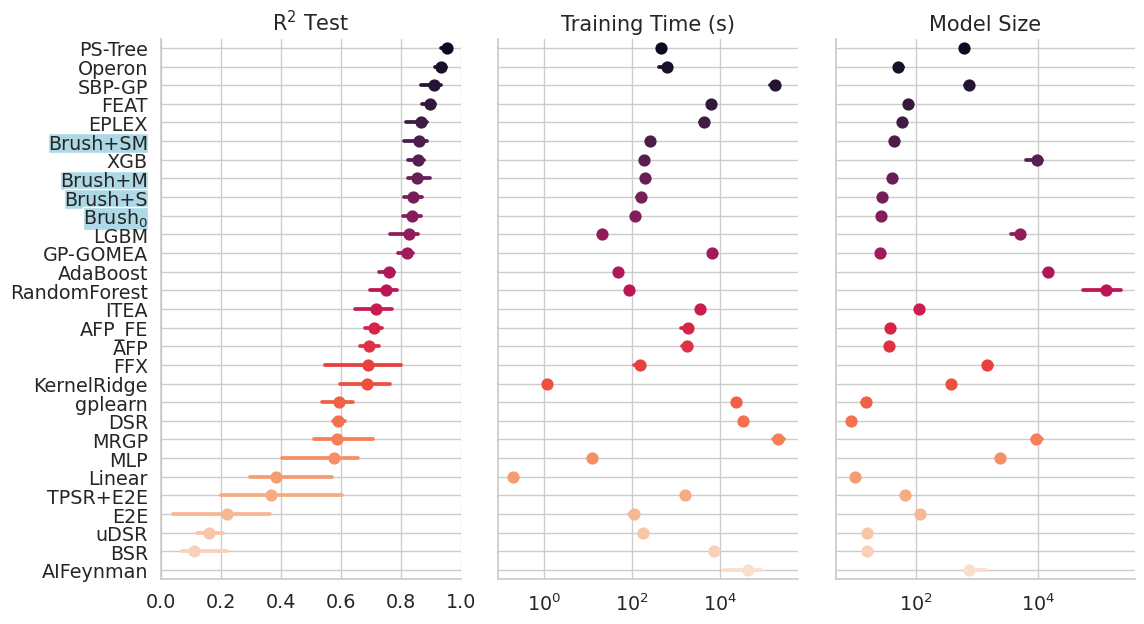

In [13]:
# Make the PairGrid
sns.set(font_scale=1.25, style='whitegrid')
# sns.set(palette='magma')
sns.despine(left=True, bottom=True)

df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

# different options
x_vars=[
#         'r2_test_norm',
        'r2_test',
#         'r2_test_rank',
#        'rmse_test',
       'training time (s)',
#         'log_mse_test',
        'model_size',
#         'model_size_rank',
]
order = df_plot.groupby('algorithm')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index

# order = order[:10].tolist()
# order += ['TPSR+E2E', 'E2E', 'uDSR', 'DSR']

print(order)

display(df_plot[x_vars])
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5, # 3.75, 
                 aspect=0.6, # 1.25,
                  hue="algorithm",
                  hue_order=order,
                  palette=sns.color_palette("rocket", n_colors=len(order)),
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      hue_order=order,
      palette=sns.color_palette("rocket", n_colors=len(order)),
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for i, (ax, title) in enumerate(zip(g.axes.flat, titles)):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([0,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
    
    for ticklbl in ax.yaxis.get_ticklabels():
        if "Brush" in ticklbl.get_text():
            ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
            # ticklbl.set_c('blue')

    # Draw a reference line on baseline
    # unif = (df_plot[ df_plot['algorithm']=='Brush+SM'])[x_vars[i]].median()
    # ax.axvline(x=unif, ymin=0.025, ymax=0.975, color='gray', ls='--', zorder=-999)


save(name='_'.join(['pairgrid-pointplot']+x_vars))

Index(['E2E', '*Brush+S', 'uDSR', '*Brush+M', '*Brush+SM', 'PS-Tree',
       'TPSR+E2E', '*DSR'],
      dtype='object', name='*algorithm*')


,training time (s)
705,190.647411
706,198.198378
707,208.295582
708,211.142325
709,209.983932
...,...
3459,142.106970
3460,154.041255
3461,179.350444
3462,150.151255


/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  func(x=x, y=y, **kwargs)
/home/guilherme/miniconda3/envs/python3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  func(x=x, y=y, **kwargs)


saving ../paper//pairgrid-pointplot_training-time-(s).pdf


<Figure size 640x480 with 0 Axes>

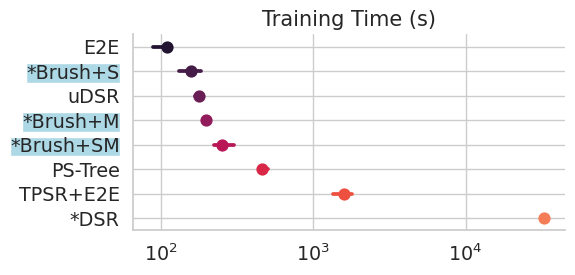

In [14]:
# Make the PairGrid
sns.set(font_scale=1.25, style='whitegrid')
# sns.set(palette='magma')
sns.despine(left=True, bottom=True)

df_plot=df_sum.copy()

df_plot = df_plot[df_plot["algorithm"].isin([
    'Brush_0',
    'Brush+S',
    'Brush+M',
    'Brush+SM',

    "Brush (C-D-UCB1)",
    "Brush (D-TS)",
    "Brush (C-D-TS)",

    "Brush",
    "Brush (D-UCB1)",
    "Brush wo split",
    "Brush wo split (D-UCB1)",

    'Brush w/ split (no MAB)',
    'Brush w/o split (no MAB)',
    'Brush w/o split (D-UCB1)',

    'Brush w/ split (D-UCB1)',
    'Brush w/ split (C-D-UCB1)',
    'Brush w/ split (D-TS)',
    'Brush w/ split (C-D-TS)',

    "uDSR",
    "DSR",
    "E2E",
    "TPSR+E2E",
    "PS-Tree",
    "NeSymRes 10M",
    "NeSymRes 100M",
])]

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

# different options
x_vars=[
#         'r2_test_norm',
#        'r2_test',
#         'r2_test_rank',
#       'rmse_test',
#         'log_mse_test',
#        'model_size',
#         'model_size_rank',
       'training time (s)',
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index

print(order)

display(df_plot[x_vars])
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=3, 
                 aspect=2,
                  hue="*algorithm*",
                  hue_order=order,
                  palette=sns.color_palette("rocket", n_colors=10),
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      hue_order=order,
      palette=sns.color_palette("rocket", n_colors=10),
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)
    
    for ticklbl in ax.yaxis.get_ticklabels():
        if "Brush" in ticklbl.get_text():
            ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0.1)) # boxstyle='round',
            # ticklbl.set_c('blue')

save(name='_'.join(['pairgrid-pointplot']+x_vars))

## effect of friedman datasets

['PS-Tree', 'Operon', 'SBP-GP', 'FEAT', 'Brush+SM', 'Brush+M', 'EPLEX', 'XGB', 'Brush+S', '$Brush_0$', 'TPSR+E2E', 'E2E', 'uDSR', 'DSR']


/tmp/ipykernel_363322/3011536971.py:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(ax=ax,
/tmp/ipykernel_363322/3011536971.py:35: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g2 = sns.pointplot(ax=ax,


saving ../paper//friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf


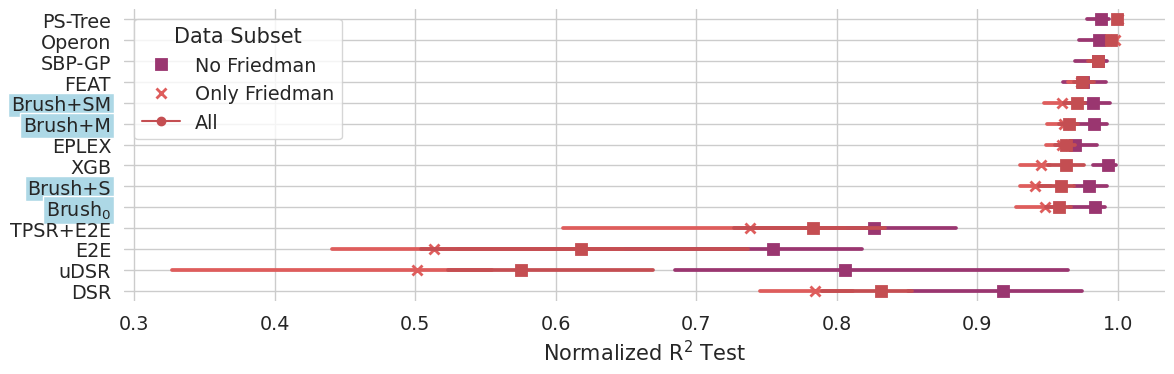

In [15]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['algorithm','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test_norm']:
    h = plt.figure(figsize=(12,4))
    ax = plt.gca()
    order = df_plot.groupby('algorithm')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index[:10].tolist() # Change here to show only topN individuals
    
    order += ['TPSR+E2E', 'E2E', 'uDSR', 'DSR']
    print(order)
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='algorithm',
                  hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  markers=['s','x'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  #legend_out=True
                 )
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='algorithm',
#                   hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  markers = 's',
                  #legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)

        for ticklbl in ax.yaxis.get_ticklabels():
            if "Brush" in ticklbl.get_text():
                ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=2)) # boxstyle='round',
                # ticklbl.set_c('blue')

    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

# training time versus dataset size

In [16]:
check_time = False
if check_time:
    import pandas as pd
    # for dataset, dfg in df_sum.groupby('dataset'):
    def get_size(dataset,i):
        df = pd.read_csv(datadir+dataset+'/'+dataset+'.tsv.gz',sep='\t') 
        return df.shape[i]

    df_sum.loc[:,'dataset_nsamples'] = df_sum['dataset'].apply(lambda x: get_size(x,0))
    df_sum.loc[:,'dataset_nsamples_train'] = df_sum['dataset'].apply(lambda x: min(get_size(x,0),10000))
    df_sum.loc[:,'dataset_nfeatures'] = df_sum['dataset'].apply(lambda x: get_size(x,1))
    df_sum.loc[:,'dataset_npoints'] = df_sum['dataset_nsamples']*df_sum['dataset_nfeatures']
    df_sum

In [17]:
if check_time:
    df_sum.algorithm.unique()

In [18]:
if check_time:

    df_sum['Method Family'] = df_sum['algorithm'].apply(lambda x: 'Operon' if x=='Operon' else 'XGB' if x=='XGB' else 'Other Non-GP SR' if x in nongp_algs else 'Other GP SR' if x in gp_algs else 'Other ML')

    order = [
        # 'FEAT SD-Split',
        # # 'FEAT S-Split',
        # 'FEAT D-Split',
        # 'FEAT(e-lex)',

        'B-wo-split',
        'Baseline',
        'Baseline-500',
        "C-D-UCB1",
        "C-D-UCB1-500",
        "C-D-TS",
        "D-UCB1",
        "D-TS",
    ]

    marker_choice = {
        # "FEAT S-Split"  : '<',
        # # "FEAT SD-Split"  : '*',
        # "FEAT D-Split"  : 'o',
        # "FEAT(e-lex)" : 's',

        'B-wo-split' : 's',
        'Baseline' : '*',
        'Baseline-500' : 'o',
        "C-D-UCB1" : '<',
        "C-D-UCB1-500" : '>',
        "C-D-TS" : '>',
        "D-UCB1" : 's',
        "D-TS" : 'o',
    }

    for col in ['dataset_nsamples_train','dataset_nsamples','dataset_nfeatures','dataset_npoints']:
        sns.set(palette='tab20')
        sns.set_style('whitegrid')
        sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.5})

        plt.figure(figsize=(6,6))
        ax = sns.lineplot(
            data=df_sum.loc[df_sum.algorithm.isin([
                #'Operon',
                # 'FEAT SD-Split',
                # 'FEAT S-Split',
                # 'FEAT D-Split',
                # 'FEAT(e-lex)',
                #'EPLEX',
                #'SBP-GP',
                #'XGB',
                #'DSR',

                'B-wo-split',
                'Baseline',
                'Baseline-500',
                "C-D-UCB1",
                "C-D-UCB1-500",
                "C-D-TS",
                "D-UCB1",
                "D-TS",
                ])],
            x = col,
            y = 'training time (hr)',
    #         hue='Method Family',
    #         style='Method Family',
            hue='algorithm',
            hue_order=order,
            style='algorithm',
            markers=marker_choice,
            markersize=8,
            markerfacecolor=None,
            err_style='bars',
            alpha=0.85
    #         facecolors=None
    #         scatter_kws = {'facecolors':'none'}
        )
        ax.set_yscale('log')
        ax.set_xscale('log')
    #     plt.legend(loc=[1.01,0])
        plt.xlabel(col.replace('_',' ').title())
        plt.ylabel('Training Time (hr)')
        save('training_time_'+col)

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

Plot the method results as trade-offs between accuracy and simplicity

In [19]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

/tmp/ipykernel_363322/2722663606.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pareto_data = data.groupby('algorithm').median()


PF: [9, 0, 7, 6, 21, 22]
PF: [18, 27, 14, 8, 12, 24]
PF: [5, 28, 1, 11, 26]
PF: [2, 15, 16, 17]
PF: [25, 13, 19, 4]
$Brush_0$ 11.0 7.0
AFP 18.0 9.25
AFP_FE 18.0 10.0
AIFeynman 29.0 22.0
AdaBoost 15.5 27.0
BSR 26.0 4.0
Brush+M 8.0 10.75
Brush+S 11.0 7.0
Brush+SM 8.5 11.0
DSR 21.0 2.0
E2E 26.0 18.0
EPLEX 11.0 14.0
FEAT 7.0 16.0
FFX 16.25 22.0
GP-GOMEA 12.0 8.0
ITEA 16.0 18.0
KernelRidge 14.0 20.0
LGBM 11.0 25.0
Linear 22.0 2.5
MLP 16.0 24.0
MRGP 19.0 27.0
Operon 3.0 15.0
PS-Tree 2.0 20.0
RandomForest 15.5 29.0
SBP-GP 5.0 21.0
TPSR+E2E 23.0 15.0
XGB 9.0 27.0
gplearn 21.0 4.0
uDSR 26.0 4.0
saving ../paper//pareto_plot_r2_test_rank_model_size_rank.pdf


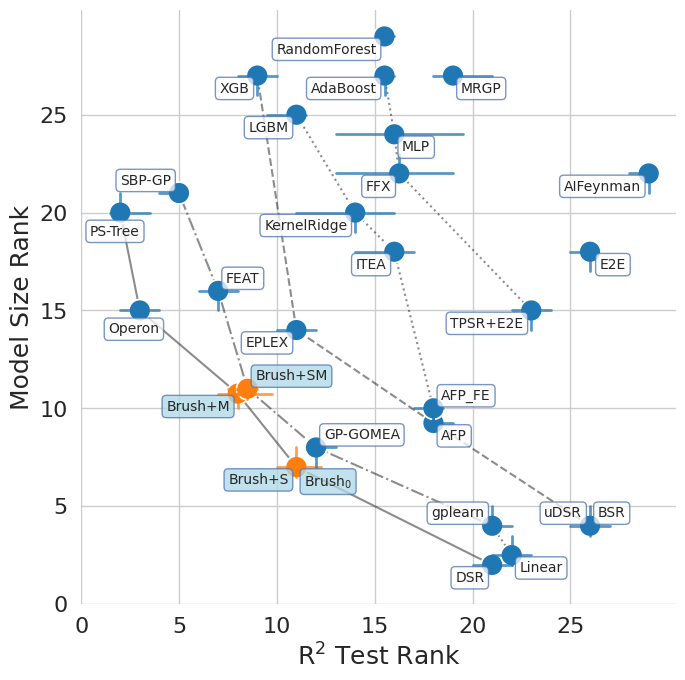

In [191]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
# xcol  = 'r2_test'
ycol = 'model_size_rank'
# ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('algorithm').median()
pareto_data['is brush'] = pareto_data.index.str.contains("Brush")

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
# objs[:,0] = -objs[:,0]
levels = 5 # Change here to include or exclude models
styles=['-','-.','--',':', ':', ':', ':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette='tab10',  # pallete,
                         # n_colors=pareto_data.pareto_rank.nunique(), 
                         n_colors=2, 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('algorithm').median(),
    data = pareto_data,
    x = xcol,
    y = ycol,
#     style='algorithm',
#     style='pareto_rank',
    hue = 'is brush', # 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
xoff = .4
yoff = 0.3
# xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear', 'AFP', 'MLP','MRGP','$Brush_0$']: # ,"Brush (C-D-TS)*"   "Brush wo split*", "Brush (C-D-UCB1)*", "Brush (D-UCB1)*",
        x=row[xcol]+xoff
        ha='left'
    elif idx in ['Operon', 'PS-Tree',"Brush wo split (D-UCB1)"]: # '$Brush_0$',
        x = row[xcol]+1
        y -= yoff
    elif idx  in ['uDSR','B-wo-split', 'SBP-GP', 'Brush', "Brush+M (C-D-UCB1)",]: # 'Baseline*', 
        #x = row[xcol]+1
        y = row[ycol]+1
    elif idx in ['gplearn']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
    elif idx in []: # 
        x=row[xcol]+xoff 
        y = row[ycol]+1
    elif idx in ['FEAT',  'Brush+SM', 'GP-GOMEA', 'FEAT S-Split', 'AFP_FE',  'BSR',  "gplearn",]: # "Brush (D-UCB1)*",
#         x -= xoff
        x=row[xcol]+xoff
        y = row[ycol]+1
        # if idx == 'GP-GOMEA*':
        #     x=row[xcol] -0.75
        #     y += 0.5
        ha='left'
    elif idx in ['E2E', 'NeSymRes 10M', "D-TS", ]: #, 'DSR*', 'D-UCB1*',  "Brush*"  "GP-GOMEA*", 
        ha='left'
        x = row[xcol]+0.5
        
    facecolor = 'w'
    if "Brush" in idx:
        facecolor = 'lightblue'

    plt.text(s=idx,
             x = x, 
             y = y,
             fontsize=10,
             ha=ha,
             va='top',
             bbox=dict(facecolor=facecolor, edgecolor='b', boxstyle='round', alpha=0.75)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('algorithm'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    print(alg, x, y)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.75,
             lw=2,
             # color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.75,
             lw=2,
             # color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    i += 1
    
ax.set_aspect(1.0)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ticksize=16
plt.xticks([0,5,10,15,20,25],fontsize=ticksize)
plt.yticks([0,5,10,15,20,25],fontsize=ticksize)
# ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

/tmp/ipykernel_363322/1444259981.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pareto_data = data[data['algorithm'] != 'Linear'].groupby('algorithm').median()


PF: [16, 17, 25, 6, 21]
PF: [18, 4, 0, 8, 20]
PF: [22, 7, 12, 23]
PF: [10, 13, 15, 11]
PF: [27, 24, 1, 14]
$Brush_0$ 11.0 115.83310723304749
AFP 18.0 1783.2957089543343
AFP_FE 18.0 1829.5131447315216
AIFeynman 29.0 42842.21329188347
AdaBoost 15.5 47.922410786151886
BSR 26.0 7200.007610917091
Brush+M 8.0 197.31887686252594
Brush+S 11.0 156.31066423654556
Brush+SM 8.5 251.30022382736206
DSR 21.0 32615.11300331354
E2E 26.0 108.61738801002502
EPLEX 11.0 4297.035191595554
FEAT 7.0 6250.729626893997
FFX 16.25 147.70063120126724
GP-GOMEA 12.0 6620.086624860764
ITEA 16.0 3554.4253093600273
KernelRidge 14.0 1.1532334685325623
LGBM 11.0 20.992564022541046
MLP 16.0 12.30481082201004
MRGP 19.0 200748.5651602745
Operon 3.0 622.5887185335159
PS-Tree 2.0 462.23905140161514
RandomForest 15.5 83.63586246967316
SBP-GP 5.0 169928.58595365286
TPSR+E2E 23.0 1576.371304988861
XGB 9.0 188.729117333889
gplearn 21.0 23148.80387175083
uDSR 26.0 176.64262557029724
saving ../paper//pareto_plot_r2_test_rank_traini

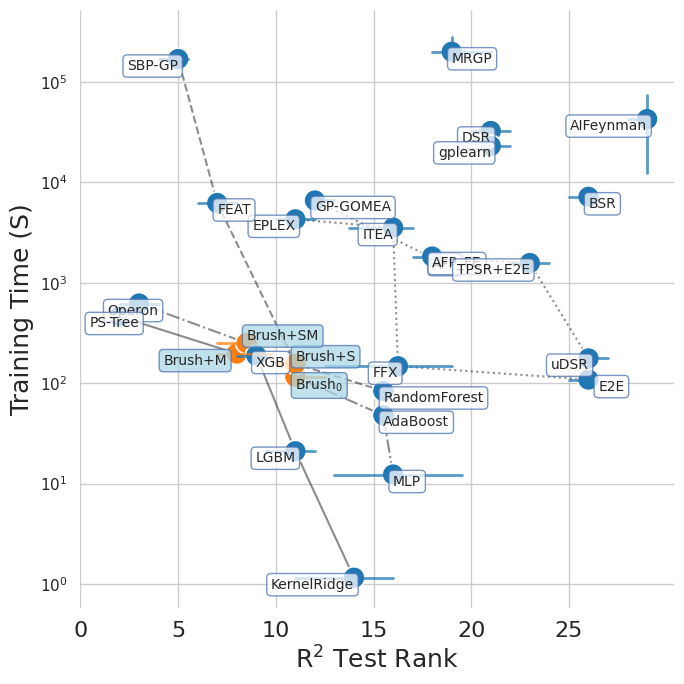

In [193]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
# xcol  = 'r2_test'
# ycol = 'model_size_rank'
ycol = 'training time (s)'
# ycol = 'model_size'
palette = 'viridis'
# outline pareto front
 # ok we get it you can do faster but stop screwing scale
pareto_data = data[data['algorithm'] != 'Linear'].groupby('algorithm').median()
pareto_data['is brush'] = pareto_data.index.str.contains("Brush")

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
# objs[:,0] = -objs[:,0]
levels = 5 # Change here to include or exclude models
styles=['-','-.','--',':', ':', ':', ':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette='tab10', #palette, 
                         # n_colors=pareto_data.pareto_rank.nunique(), 
                         n_colors=2, 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('algorithm').median(),
    data = pareto_data,
    x = xcol,
    y = ycol,
#     style='algorithm',
#     style='pareto_rank',
    hue = 'is brush', # 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
xoff = 0 #.4
yoff = 0 #.3
# xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    va='top'
    
    if idx in ['Linear', 'AFP', 'MLP','MRGP',]: # ,"Brush (C-D-TS)*"   "Brush wo split*", "Brush (C-D-UCB1)*", "Brush (D-UCB1)*",
        x=row[xcol]+xoff
        ha='left'
    elif idx in ['Operon', 'PS-Tree',"Brush wo split (D-UCB1)"]: # '$Brush_0$',
        x = row[xcol]+1
        y -= yoff
    elif idx  in ['uDSR','B-wo-split', 'SBP-GP', 'Brush', "Brush+M (C-D-UCB1)",]: # 'Baseline*', 
        #x = row[xcol]+1
        y = row[ycol]+1
    elif idx in ['gplearn']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
    elif idx in []: # 
        x=row[xcol]+xoff 
        y = row[ycol]+1
    elif idx in ['FEAT', 'GP-GOMEA', 'FEAT S-Split', 'AFP_FE',  'BSR',  "gplearn",]: # "Brush (D-UCB1)*",
#         x -= xoff
        x=row[xcol]+xoff
        y = row[ycol]+1
        # if idx == 'GP-GOMEA*':
        #     x=row[xcol] -0.75
        #     y += 0.5
        ha='left'
    elif idx in ['E2E', 'NeSymRes 10M', "D-TS", ]: #, 'DSR*', 'D-UCB1*',  "Brush*"  "GP-GOMEA*", 
        ha='left'
        x = row[xcol]+0.5
    elif idx in [ 'Brush+SM',  'Brush+S',   ]:
        ha='left'
        va = 'bottom'
    elif idx in [ 'XGB',  '$Brush_0$', 'RandomForest', 'AdaBoost']:
        ha='left'
        va = 'top'
        if idx == 'XGB':
            ha='right'
            x += 1.5
    
    if idx == 'Brush+M':
        # ha='right'
        x -= 0.5
        
    facecolor = 'w'
    if "Brush" in idx:
        facecolor = 'lightblue'

    plt.text(s=idx,
             x = x, 
             y = y,
             fontsize=10,
             ha=ha,
             va=va,
             bbox=dict(facecolor=facecolor, edgecolor='b', boxstyle='round', alpha=0.75)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('algorithm'):
    if alg == 'Linear': continue
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    print(alg, x, y)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.75,
             lw=2,
             # color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.75,
             lw=2,
             # color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    i += 1
    
# ax.set_aspect(1.0)
ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ticksize=16
plt.xticks([0,5,10,15,20,25],fontsize=ticksize)
# plt.yticks([0,5,10,15,20,25],fontsize=ticksize)
ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

/tmp/ipykernel_363322/2656730584.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pareto_data = data.groupby('algorithm').median()


,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,friedman_dataset,symbolic_alg,...,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm,is brush
algorithm,,,,,,,,,,,,,,,,,,,,,
$Brush_0$,16322.5,115.833107,0.284728,0.388952,0.838537,27.00,0.032176,0.838537,1.0,1.0,...,0.958317,7.00,1.179272e-04,11.00,0.902065,12.0,0.115296,12.00,0.088158,True
AFP,13879.5,1783.295709,0.438313,0.519851,0.695354,36.50,0.495360,0.695354,1.0,1.0,...,0.884488,9.25,1.837302e-04,18.00,0.765260,18.0,0.252182,18.00,0.210775,False
AFP_FE,13879.5,1829.513145,0.430157,0.518399,0.709005,37.75,0.508198,0.709005,1.0,1.0,...,0.883068,10.00,1.795716e-04,18.00,0.762833,18.0,0.248659,18.00,0.200855,False
AIFeynman,13879.5,42842.213292,2.897746,1.202983,-0.437132,742.00,11.900615,0.000000,1.0,1.0,...,0.000000,22.00,6.516910e-03,27.50,0.000000,29.0,1.000000,29.00,1.000000,False
AdaBoost,13879.5,47.922411,0.350307,0.459370,0.759914,14668.50,0.013312,0.759914,1.0,0.0,...,0.916377,27.00,6.132360e-02,15.50,0.806699,16.0,0.205496,16.00,0.165502,False
BSR,13879.5,7200.007611,0.996942,0.806952,0.109722,16.00,2.000002,0.109722,1.0,1.0,...,0.603322,4.00,8.076675e-05,26.00,0.120089,26.0,0.573259,26.00,0.547437,False
Brush+M,16322.5,197.318877,0.239108,0.365395,0.855292,41.00,0.054811,0.855292,1.0,1.0,...,0.965605,10.75,1.803885e-04,8.00,0.927644,9.0,0.092925,9.00,0.069221,True
Brush+S,16322.5,156.310664,0.257879,0.387996,0.841347,28.00,0.043420,0.841347,1.0,1.0,...,0.959350,7.00,1.350195e-04,11.00,0.905188,11.0,0.112193,10.75,0.085466,True
Brush+SM,16322.5,251.300224,0.244790,0.360356,0.861155,43.00,0.069806,0.861155,1.0,1.0,...,0.970850,11.00,1.948046e-04,8.50,0.937633,8.5,0.096987,8.50,0.065724,True


PF: [8, 26, 13, 0, 6, 5, 7, 20, 21]
PF: [17, 1, 2, 10, 11, 23]
$Brush_0$ 0.8385373503799041 27.0
AFP 0.6953538991447503 36.5
AFP_FE 0.7090053482676721 37.75
Brush+M 0.8552919985764716 41.0
Brush+S 0.8413471058433721 28.0
Brush+SM 0.861154944983455 43.0
DSR 0.5915363488850844 8.5
EPLEX 0.8681893735924611 58.0
FEAT 0.8962718008079189 75.25
GP-GOMEA 0.8204368163886107 25.25
Linear 0.38368413569813875 10.0
Operon 0.9343873312186631 50.0
PS-Tree 0.9536731159948553 612.25
SBP-GP 0.910415731540627 738.5
gplearn 0.5936104039947055 15.0


/tmp/ipykernel_363322/2656730584.py:207: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pareto_data = data.groupby('algorithm').median()


,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,friedman_dataset,symbolic_alg,...,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm,is brush,pareto_rank
algorithm,,,,,,,,,,,,,,,,,,,,,
$Brush_0$,16322.5,115.833107,0.284728,0.388952,0.838537,27.00,0.032176,0.838537,1.0,1.0,...,7.00,1.179272e-04,11.00,0.902065,12.0,0.115296,12.00,0.088158,True,0.0
AFP,13879.5,1783.295709,0.438313,0.519851,0.695354,36.50,0.495360,0.695354,1.0,1.0,...,9.25,1.837302e-04,18.00,0.765260,18.0,0.252182,18.00,0.210775,False,1.0
AFP_FE,13879.5,1829.513145,0.430157,0.518399,0.709005,37.75,0.508198,0.709005,1.0,1.0,...,10.00,1.795716e-04,18.00,0.762833,18.0,0.248659,18.00,0.200855,False,1.0
AdaBoost,13879.5,47.922411,0.350307,0.459370,0.759914,14668.50,0.013312,0.759914,1.0,0.0,...,27.00,6.132360e-02,15.50,0.806699,16.0,0.205496,16.00,0.165502,False,-1.0
BSR,13879.5,7200.007611,0.996942,0.806952,0.109722,16.00,2.000002,0.109722,1.0,1.0,...,4.00,8.076675e-05,26.00,0.120089,26.0,0.573259,26.00,0.547437,False,-1.0
Brush+M,16322.5,197.318877,0.239108,0.365395,0.855292,41.00,0.054811,0.855292,1.0,1.0,...,10.75,1.803885e-04,8.00,0.927644,9.0,0.092925,9.00,0.069221,True,0.0
Brush+S,16322.5,156.310664,0.257879,0.387996,0.841347,28.00,0.043420,0.841347,1.0,1.0,...,7.00,1.350195e-04,11.00,0.905188,11.0,0.112193,10.75,0.085466,True,0.0
Brush+SM,16322.5,251.300224,0.244790,0.360356,0.861155,43.00,0.069806,0.861155,1.0,1.0,...,11.00,1.948046e-04,8.50,0.937633,8.5,0.096987,8.50,0.065724,True,0.0
DSR,13879.5,32615.113003,0.502131,0.564958,0.591536,8.50,9.059754,0.591536,1.0,1.0,...,2.00,8.207757e-07,21.00,0.624921,21.0,0.351669,21.00,0.281973,False,0.0


$Brush_0$ 0.8385373503799041 27.0
Brush+M 0.8552919985764716 41.0
Brush+S 0.8413471058433721 28.0
Brush+SM 0.861154944983455 43.0
GP-GOMEA 0.8204368163886107 25.25
Operon 0.9343873312186631 50.0


/tmp/ipykernel_363322/3267894211.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  h.tight_layout()


saving ../paper//pareto_plot_r2_test_model_size.pdf


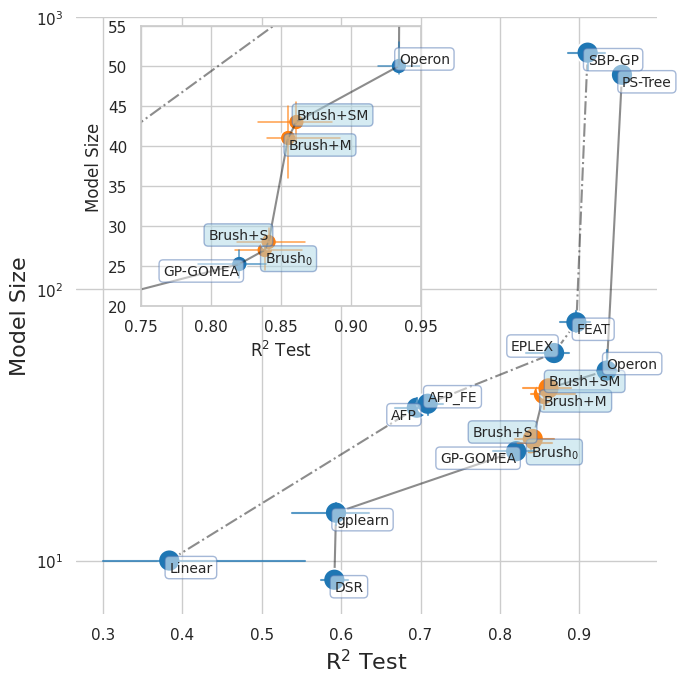

In [200]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=16
fig, ax = plt.subplots(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
# xcol = 'r2_test_rank'
xcol  = 'r2_test'
# ycol = 'model_size_rank'
ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('algorithm').median()
pareto_data['is brush'] = pareto_data.index.str.contains("Brush")

display(pareto_data)
# fn_func = (pareto_data[xcol] >= 0.5) & (pareto_data[ycol] <= 100)
fn_func = (pareto_data[xcol] >= 0.0)

pareto_data = pareto_data[fn_func]

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
objs[:,0] = -objs[:,0]
levels = 2 # Change here to include or exclude models
styles=['-','-.','--',':', ':', ':', ':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks

for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

pareto_data = pareto_data[(pareto_data['pareto_rank']>=0) 
                          & (pareto_data['pareto_rank']<levels)]

cmap = sns.color_palette(palette='tab10',  # pallete,
                         # n_colors=pareto_data.pareto_rank.nunique(), 
                         n_colors=2, 
                         desat=None, 
                         as_cmap=False)

sns.scatterplot(
    ax = ax,
#     ax = g.ax_joint,
#     data = data.groupby('algorithm').median(),
    data = pareto_data ,
    x = xcol,
    y = ycol,
#     style='algorithm',
#     style='pareto_rank',
    hue = 'is brush', # 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
# xoff = .4
# yoff = 0.03
xoff, yoff = 0, 0
flip= False
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='left'
    va='top'
    
    if idx in ['AFP_FE','Brush+SM','Operon']:
        x=row[xcol]+xoff
        #ha='right'
        va='bottom'

    if idx in ['AFP','GP-GOMEA']:
        x=row[xcol]+xoff
        ha='right'
        # va='bottom'

    if idx in ['Brush+S','EPLEX']:
        x=row[xcol]+xoff
        ha='right'
        va='bottom'

#     elif idx == 'Operon*':
#         x = row[xcol]#+1
#         y -= yoff
#     elif idx  in ['uDSR']: # 'Baseline*', 
#         #x = row[xcol]+1
#         y = row[ycol]+1
#     elif idx in ['gplearn*']:
# #         x -= xoff
# #         x=row[xcol]+xoff
#         y = row[ycol]+1
# #         ha='left'
#     elif idx in ['AFP_FE*']:
#         x=row[xcol]+xoff
#         y = row[ycol]#+1
#     elif idx in ['FEAT*','FEAT S-Split*', 'BSR*',"C-D-UCB1*",'Brush wo split*']:
# #         x -= xoff
#         x=row[xcol]+xoff
#         y = row[ycol]+4
#         ha='left'
#     elif idx in ['AFP*', 'E2E', 'NeSymRes 10M', "D-TS*", "GP-GOMEA*"]: #, 'DSR*', 'D-UCB1*', 
#         ha='left'
#         x = row[xcol]#+0.5
#     elif idx in ['B-wo-split*']:
#         ha='left'

    facecolor = 'w'
    if "Brush" in idx: #,
        facecolor = 'lightblue'

    #ha='left'
    plt.text(s=idx,
            x = x, 
            y = y,
            ha=ha,
            fontsize=10,
            va=va,
            bbox=dict(facecolor=facecolor, edgecolor='b', boxstyle='round', alpha=.5)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('algorithm'):
    if not alg in pareto_data[(pareto_data['pareto_rank']>=0) 
                    & (pareto_data['pareto_rank']<levels)].index:
        continue
    

    x = dg[xcol].median() 
    y = dg[ycol].median()
    print(alg, x, y)
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.75,
             lw=1.5,
            #  color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.75,
             lw=1.5,
            #  color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    i += 1
    
# ax.set_aspect(1.0)
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ticksize=16
# plt.xticks([0,5,10,15,20],fontsize=ticksize)
# plt.yticks([0,5,10,15,20],fontsize=ticksize)
ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)

sns.despine(left=True, bottom=True)

ax2 = plt.axes([0.2125, 0.55, .4, 0.4]) #, facecolor='lightgray')
ax2.set_zorder(3)
sns.scatterplot(
    ax=ax2,
    data = pareto_data ,
    x = xcol,
    y = ycol,
#     style='algorithm',
#     style='pareto_rank',
    hue = 'is brush', # 'pareto_rank',
    s=125,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)

ax2.set_zorder(4)

pareto_data = data.groupby('algorithm').median()
pareto_data['is brush'] = pareto_data.index.str.contains("Brush")
pareto_data = pareto_data[fn_func]
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
display(pareto_data)
i=0
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=2)
#     plt.gca().set_zorder(10)
    i+=1

i = 0
for alg, dg in data.groupby('algorithm'):
    if not ("Brush" in alg or alg in ['Operon', 'GP-GOMEA']):
        continue

    x = dg[xcol].median() 
    y = dg[ycol].median()
    print(alg, x, y)
    # display(dg)
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.75,
             lw=1.1,
             # color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.75,
             lw=1.1,
             # color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
             color=cmap[1 if pareto_data.loc[alg,'is brush'] else 0]
#              color='b'
            )
    i += 1
    
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='left'
    va='top'
    
    if idx in ['AFP_FE','Brush+SM','Operon']:
        x=row[xcol]+xoff
        #ha='right'
        va='bottom'

    if idx in ['AFP','GP-GOMEA']:
        x=row[xcol]+xoff
        ha='right'
        # va='bottom'

    if idx in ['Brush+S','EPLEX']:
        x=row[xcol]+xoff
        ha='right'
        va='bottom'

#     elif idx == 'Operon*':
#         x = row[xcol]#+1
#         y -= yoff
#     elif idx  in ['uDSR']: # 'Baseline*', 
#         #x = row[xcol]+1
#         y = row[ycol]+1
#     elif idx in ['gplearn*']:
# #         x -= xoff
# #         x=row[xcol]+xoff
#         y = row[ycol]+1
# #         ha='left'
#     elif idx in ['AFP_FE*']:
#         x=row[xcol]+xoff
#         y = row[ycol]#+1
#     elif idx in ['FEAT*','FEAT S-Split*', 'BSR*',"C-D-UCB1*",'Brush wo split*']:
# #         x -= xoff
#         x=row[xcol]+xoff
#         y = row[ycol]+4
#         ha='left'
#     elif idx in ['AFP*', 'E2E', 'NeSymRes 10M', "D-TS*", "GP-GOMEA*"]: #, 'DSR*', 'D-UCB1*', 
#         ha='left'
#         x = row[xcol]#+0.5
#     elif idx in ['B-wo-split*']:
#         ha='left'

    facecolor = 'w'
    if "Brush" in idx or idx in ['Operon', 'GP-GOMEA']: #,
        if "Brush" in idx:
            facecolor = 'lightblue'

        #ha='left'
        plt.text(s=idx,
                x = x, 
                y = y,
                ha=ha,
                fontsize=10,
                va=va,
                bbox=dict(facecolor=facecolor, edgecolor='b', boxstyle='round', alpha=.5)
                )
# ax2.set_title('zoom')
ax2.set_xlim([0.75, .95])
ax2.set_ylim([20, 55])
# plt.xlabel("")
# plt.ylabel("")
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize-4)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize-4)

save(name="pareto_plot_"+xcol+'_'+ycol)

In [23]:
objs

array([[            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [-7.59914190e-01,  1.46685000e+04],
       [-1.09722490e-01,  1.60000000e+01],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [            inf,             inf],
       [-2.18149268e-01,  1.17500000e+02],
       [            inf,             inf],
       [            inf,             inf],
       [-6.91628389e-01,  1.47450000e+03],
       [            inf,             inf],
       [-7.18884243e-01,  1.11250000e+02],
       [-6.85991261e-01,  3.75000000e+02],
       [-8.26291702e-01,  5.16750000e+03],
       [            inf,             inf],
       [-5.75879197e-01,  2.40200000e+03],
       [-5.87610435e-01,  9.21950000e+03],
       [            inf,             inf],
       [            inf,             inf],
       [-7.49981165e-01,  1.29511000e+05],
       [   

In [24]:
pareto_data['pareto_rank']

algorithm
$Brush_0$    0.0
AFP          1.0
AFP_FE       1.0
Brush+M      0.0
Brush+S      0.0
Brush+SM     0.0
DSR          0.0
EPLEX        1.0
FEAT         1.0
GP-GOMEA     0.0
Linear       1.0
Operon       0.0
PS-Tree      0.0
SBP-GP       1.0
gplearn      0.0
Name: pareto_rank, dtype: float64

/tmp/ipykernel_363322/3070250588.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_clustermap = data[["dataset", "algorithm", "r2_test_rank"]]\


saving ../paper//clustermap.pdf


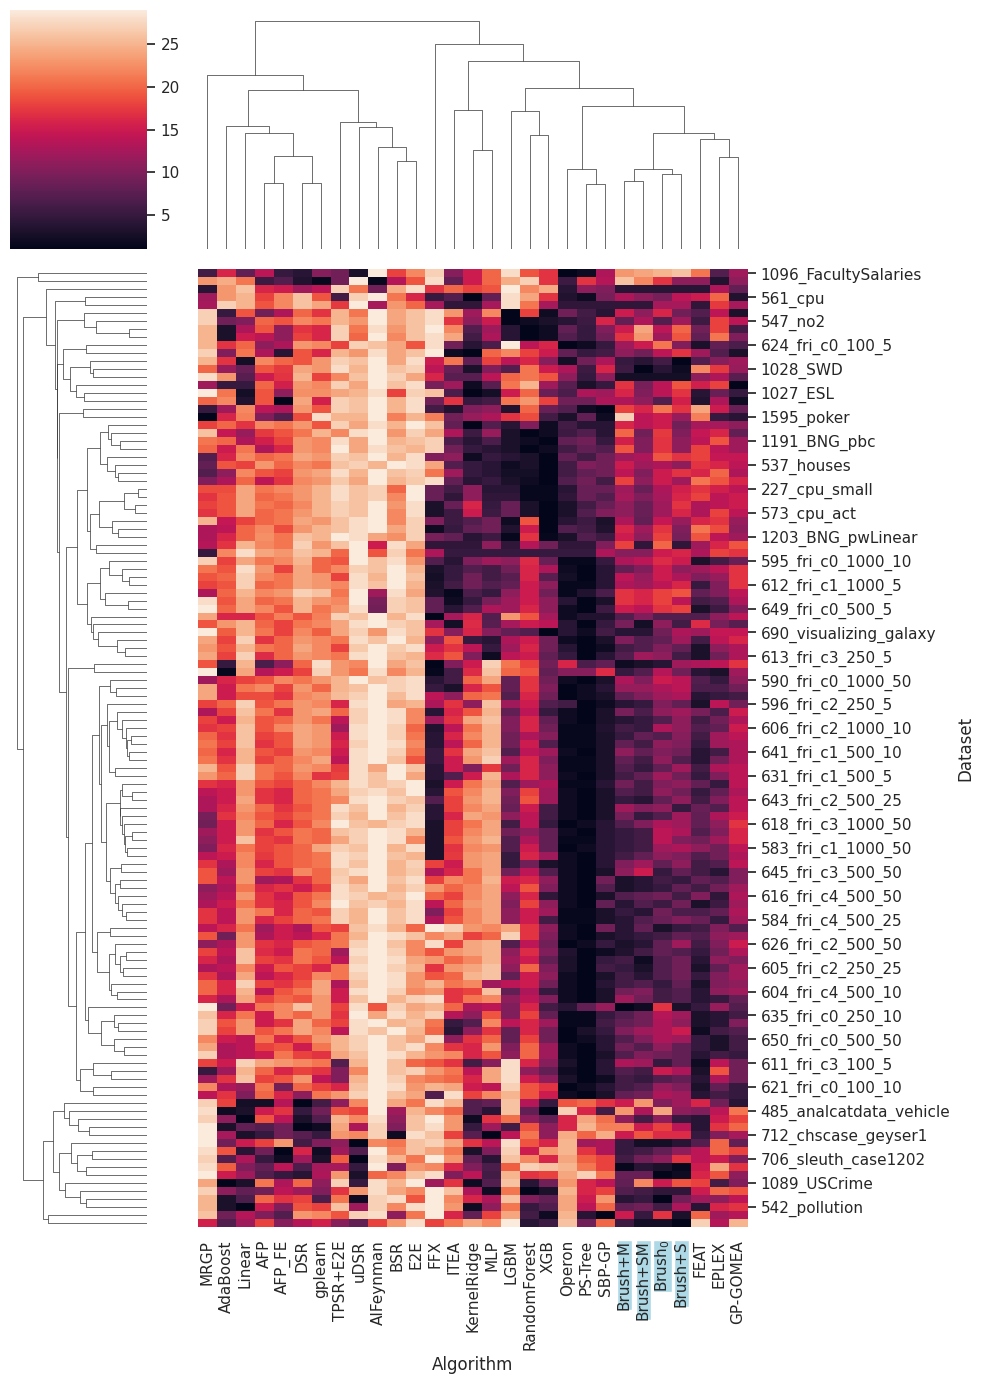

In [25]:
df_clustermap = data[["dataset", "algorithm", "r2_test_rank"]]\
        .groupby(["dataset", "algorithm"]).mean().reset_index().pivot(
            "dataset", columns="algorithm").fillna(data["algorithm"].nunique())

df_clustermap.columns = df_clustermap.columns.droplevel()

g = sns.clustermap(
    df_clustermap,
    figsize=(10, 14)
)

for ticklbl in g.ax_heatmap.xaxis.get_ticklabels():
    if "Brush" in ticklbl.get_text():
        ticklbl.set_bbox(dict(facecolor='lightblue', edgecolor='w', alpha=1, pad=0)) # boxstyle='round',
        # ticklbl.set_c('blue')

g.ax_heatmap.set_xlabel("Algorithm")
g.ax_heatmap.set_ylabel("Dataset")

plt.tight_layout()
save(name="clustermap")

In [26]:
df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\
        .groupby(["dataset", "*algorithm*"]).mean().reset_index().pivot("dataset", columns="*algorithm*").fillna(data["*algorithm*"].nunique())

df_clustermap.columns = df_clustermap.columns.droplevel()
# df_sum
df_clustermap

/tmp/ipykernel_363322/236141615.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\


*algorithm*,$Brush_0$,AFP*,AFP_FE*,AIFeynman*,AdaBoost,BSR*,Brush+M*,Brush+S*,Brush+SM*,DSR*,...,MLP,MRGP*,Operon*,PS-Tree,RandomForest,SBP-GP*,TPSR+E2E,XGB,gplearn*,uDSR
dataset,,,,,,,,,,,,,,,,,,,,,
1027_ESL,14.0,19.0,11.0,28.0,21.0,18.0,16.0,17.0,10.0,22.5,...,2.5,29.0,6.5,13.0,20.0,12.0,24.0,8.5,22.5,25.0
1028_SWD,4.0,19.0,17.5,29.0,11.5,26.0,5.5,2.0,1.0,24.0,...,10.0,20.0,13.0,5.5,21.0,16.0,28.0,15.0,23.0,25.0
1029_LEV,7.0,19.0,1.0,29.0,22.0,25.0,13.0,15.5,11.0,24.0,...,6.0,20.0,9.0,9.0,23.0,13.0,27.0,18.0,15.5,26.0
1030_ERA,14.0,20.0,15.5,29.0,5.0,26.0,17.0,19.0,9.5,23.0,...,7.5,12.0,7.5,3.0,25.0,5.0,27.0,12.0,22.0,24.0
1089_USCrime,15.0,21.0,13.0,28.0,1.0,25.0,8.0,19.0,22.0,20.0,...,7.0,24.0,23.0,16.0,4.0,14.0,27.0,9.0,11.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687_sleuth_ex1605,4.5,9.0,14.0,28.0,11.0,24.0,7.0,4.5,6.0,12.0,...,2.0,27.0,25.0,16.0,1.0,18.0,17.0,3.0,10.0,23.0
690_visualizing_galaxy,9.0,21.0,18.0,23.0,19.5,28.0,4.0,13.0,4.0,22.0,...,10.5,29.0,4.0,2.0,7.0,6.0,24.0,1.0,19.5,27.0
695_chatfield_4,11.0,19.0,14.0,28.0,11.0,11.0,11.0,5.0,6.0,3.0,...,17.0,27.0,16.0,24.0,11.0,20.5,25.0,8.0,7.0,22.0
